In [305]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import polars as pl
from scipy.signal import butter, filtfilt, peak_widths

from sklearn.decomposition import PCA

from src.ExistingAlgorithms import max_value, area
from src.GaussianMixture import gaussian_mixture

IDX = 15
SIZE = 200
TIME = np.arange(SIZE)


PATH_SAVE_LD = 'src/Results_Uniform/Low Dimension'
PATH_SAVE_D = 'src/Results_Uniform/Density'
PATH_RESULTS = 'src/Results_Uniform'
PATH_DATA = '/home/nicolasdc/Documents/Datasets/Photon-Number-Classification/NIST CSV'

data_train = pl.read_csv(f'{PATH_DATA}/uniform_train.csv', has_header=False, separator=",").to_numpy()
data_test = pl.read_csv(f'{PATH_DATA}/uniform_test.csv', has_header=False, separator=",").to_numpy()
expected_prob = pl.read_csv(f'{PATH_DATA}/uniform_expected_prob.csv', has_header=False, separator=",").to_numpy()
db_train = pl.read_csv(f'{PATH_DATA}/db_train.csv', has_header=False, separator=",").to_numpy().flatten()
db_test = pl.read_csv(f'{PATH_DATA}/db_test.csv', has_header=False, separator=",").to_numpy().flatten()


# Before Running

In the following cells some variables are defined to guarantee the code will run without issues on your machine.

## STYLE

A version for Linux and Windows was created for the plot style.
These styles consider `latex` is installed on the machine.

Define the variable :

In [306]:
STYLE = 'src/custom.mplstyle' # Linux
# STYLE = 'src/custom_windows.mplstyle' # Windows


## LATEX

Figures are generated to allow formatting with latex files.
If `latex` is not installed on your device just set the `LATEX` variable to `False`.

In [307]:
LATEX = True
rcParams['text.usetex'] = LATEX

# Introduction

### Transition Edge Sensors

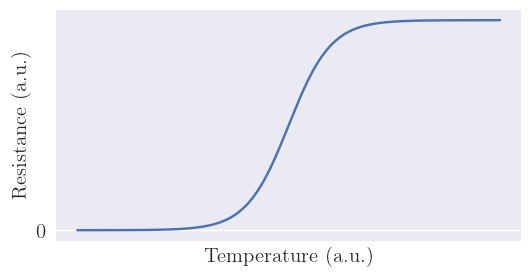

In [308]:
def sigmoid(x):
    return 1/(1+np.exp(-10*x))

x = np.linspace(-1,1,1000)

with plt.style.context(STYLE):
    plt.figure(figsize=(6,3), dpi=100)
    plt.plot(x, sigmoid(x))
    plt.xticks([])
    plt.yticks([0])
    plt.xlabel('Temperature (a.u.)')
    plt.ylabel('Resistance (a.u.)')
    # plt.savefig('assets/TransitionEdge.png', bbox_inches='tight')
    plt.show()

### Example signals

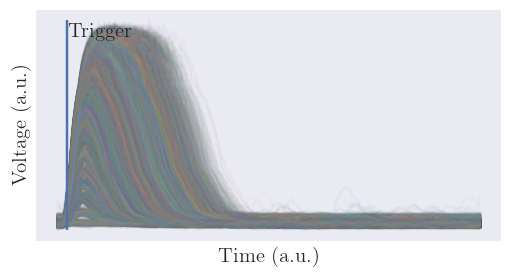

In [309]:
with plt.style.context(STYLE):
    plt.figure(figsize=(6,3), dpi=100)
    plt.plot(data_train.T,alpha=0.05)
    plt.ylabel("Voltage (a.u.)")
    plt.xlabel("Time (a.u.)")
    plt.vlines(8,ymin=0,ymax=1)
    plt.text(x = 8.6, y = 0.92, s = 'Trigger')
    plt.yticks([])
    plt.xticks([])
    # plt.savefig('assets/Traces_uniform.png', bbox_inches='tight')
    plt.show()

In [310]:
data_train.shape

(30550, 350)

### Problem Formulation

In [322]:
PATH_DATA = '/home/nicolasdc/Documents/Datasets/Photon-Number-Classification/NRC CSV'
PATH_RESULTS = 'src/Results_Large'
PATH_SAVE_LD = 'src/Results_Large/Low Dimension'
PATH_SAVE_D = 'src/Results_Large/Density'

data = pl.read_csv(f'{PATH_DATA}/traces_attn_25dB.csv', has_header=False, separator=",").to_numpy()[:,::3]

data_train = data[::2]
data_test = data[1::2]
mean_ = data_train.mean()
std_ = data_train.std()
data_train  = ((data_train - mean_) / std_)[::10]
data_test  = ((data_test - mean_) / std_)[::10]

In [323]:
Y_MAX = max_value(data_test, filtering=True)
condition = (Y_MAX < 1).flatten()
Y_MAX_ex = Y_MAX[condition]
X_MAX_ex = data_test[condition]

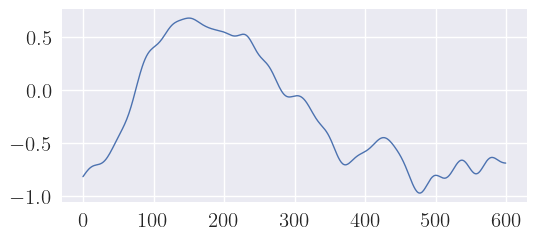

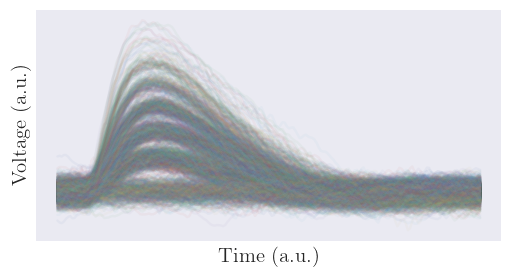

In [324]:
with plt.style.context(STYLE):
    plt.figure(figsize=(6,3), dpi=100)
    plt.plot(X_MAX_ex[1::2].T,alpha=0.05)
    plt.ylabel("Voltage (a.u.)")
    plt.xlabel("Time (a.u.)")
    plt.yticks([])
    plt.xticks([])
    # plt.savefig('assets/Traces_poisson.png', bbox_inches='tight')
    plt.show()

# Historical Methods

In [325]:
b, a = butter(5, 0.06, 'low')
data_test_filt = filtfilt(b, a, data_test[IDX])

### Maximum value

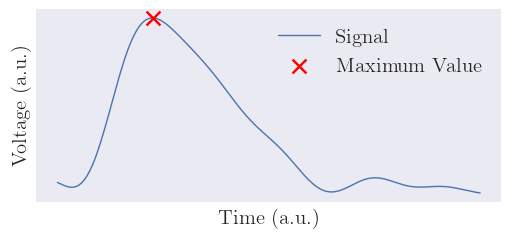

In [326]:
arg_max = np.argmax(data_test_filt)

with plt.style.context(STYLE):
    plt.figure(figsize=(6,2.5), dpi=100)
    plt.plot(data_test_filt, linewidth=1, alpha=1, label='Signal')
    plt.scatter(arg_max, data_test_filt[arg_max],s=100, marker="x", zorder=10, c="r", label='Maximum Value')
    plt.ylabel("Voltage (a.u.)")
    plt.xlabel("Time (a.u.)")
    plt.yticks([])
    plt.xticks([])
    plt.legend()
    plt.savefig('src/Figures/Trace_MAX.pdf',format="pdf")
    plt.show()

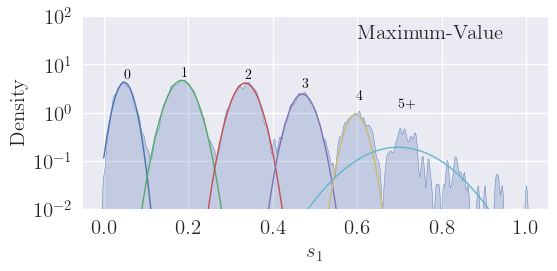

In [327]:
gm = gaussian_mixture(Y_MAX_ex,
                    X_MAX_ex,
                    means_init = None,
                    number_cluster = 6,
                    cluster_iter = 10,
                    info_sweep = 0,
                    plot_sweep = True,
                    width_plot = 6,
                    height_plot = 2.5,
                    dpi = 100,
                    tol = 1e-6,
                    style = STYLE,
                    latex = LATEX)

gm.plot_density(bw_adjust = 0.08,
                plot_gaussians = True,
                plot_scale = 'log',
                text = 'Maximum-Value',
                save_path = None)

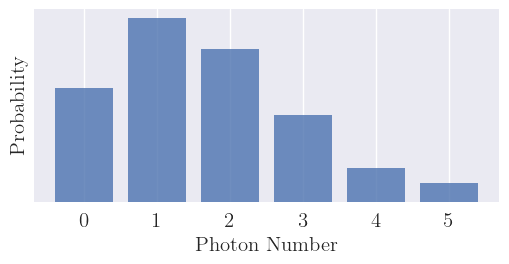

In [328]:
with plt.style.context(STYLE):
    plt.figure(figsize=(6,2.5), dpi=100)
    plt.bar(np.arange(6),np.bincount(gm.labels),alpha=0.8)
    plt.ylabel("Probability")
    plt.xlabel("Photon Number")
    plt.yticks([])
    # plt.savefig('assets/Distribution_MAX.svg', bbox_inches='tight')
    plt.show()

### Maximum Slope

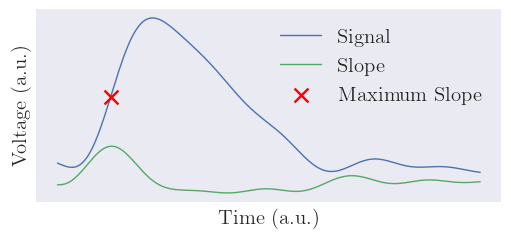

In [329]:
slope = np.gradient(data_test_filt, edge_order=2)
max_slope = np.argmax(slope)

with plt.style.context(STYLE):
    plt.figure(figsize=(6,2.5), dpi=100)
    plt.plot(data_test_filt, linewidth=1, alpha=1, label='Signal')
    plt.plot(5*slope-1, linewidth=1, alpha=1, label='Slope')
    plt.scatter(max_slope, data_test_filt[max_slope],s=100, marker="x", zorder=10, c="r", label='Maximum Slope')
    plt.ylabel("Voltage (a.u.)")
    plt.xlabel("Time (a.u.)")
    plt.yticks([])
    plt.xticks([])
    plt.legend()
    plt.savefig('src/Figures/Trace_SLOPE.pdf',format="pdf")
    plt.show()

### Pulse Lenght

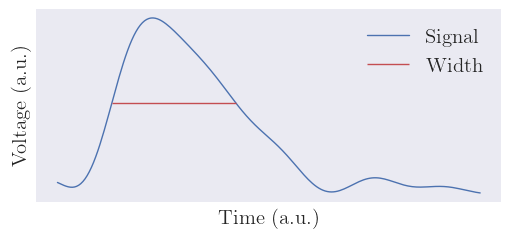

In [330]:
peak_idx = np.argmax(data_test_filt)
width = peak_widths(data_test_filt, [peak_idx], rel_height=0.5, prominence_data=None, wlen=None)

with plt.style.context(STYLE):
    plt.figure(figsize=(6,2.5), dpi=100)
    plt.plot(data_test_filt, linewidth=1, alpha=1, label='Signal')
    plt.hlines(*width[1:], color="C2", label='Width', linewidth=1)
    plt.ylabel("Voltage (a.u.)")
    plt.xlabel("Time (a.u.)")
    plt.yticks([])
    plt.xticks([])
    plt.legend()
    plt.savefig('src/Figures/Trace_WIDTH.pdf',format="pdf")
    plt.show()

### Area

In [331]:
X_AREA_ex  = area(data_test, filtering = True, plot_filter = False, threshold = 0.04)

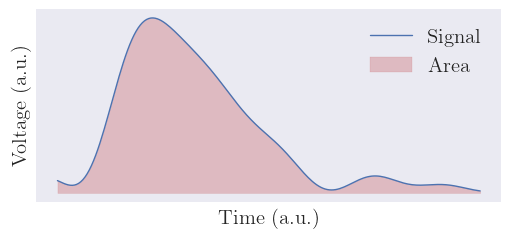

In [340]:
threshold = -0.8

with plt.style.context(STYLE):
    plt.figure(figsize=(6,2.5), dpi=100)
    plt.plot(data_test_filt, linewidth=1, alpha=1, label='Signal')
    plt.fill_between(TIME, data_test_filt, threshold, label='Area', color="C2", alpha=0.3)
    plt.ylabel("Voltage (a.u.)")
    plt.xlabel("Time (a.u.)")
    plt.yticks([])
    plt.xticks([])
    plt.legend()
    plt.savefig('src/Figures/Trace_AREA.pdf',format="pdf")
    plt.show()

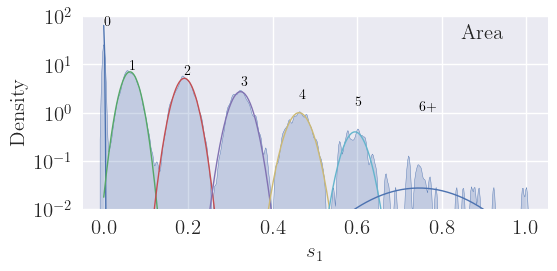

In [342]:
gm = gaussian_mixture(X_AREA_ex,
                    data_test,
                    means_init = None,
                    number_cluster = 7,
                    cluster_iter = 10,
                    info_sweep = 0,
                    tol = 1e-5,
                    plot_sweep = True,
                    width_plot = 6,
                    height_plot = 2.5,
                    dpi = 100,
                    style = STYLE,
                    latex = LATEX)

gm.plot_density(bw_adjust = 0.1,
                plot_gaussians = True,
                plot_scale = 'log',
                text = 'Area',
                save_path = None)

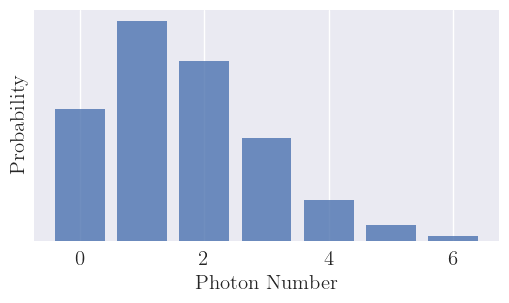

In [345]:
with plt.style.context(STYLE):
    plt.figure(figsize=(6,3), dpi=100)
    plt.bar(np.arange(7),np.bincount(gm.labels),alpha=0.8)
    plt.ylabel("Probability")
    plt.xlabel("Photon Number")
    plt.yticks([])
    # plt.savefig('assets/Distribution_AREA.svg', bbox_inches='tight')
    plt.show()

### PCA

In [346]:
pca = PCA(n_components=1)
X_PCA = pca.fit_transform(data_test)
first_component = pca.components_[0]

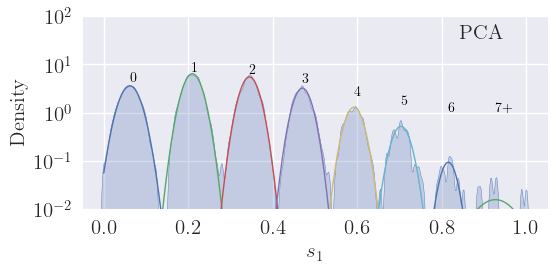

In [347]:
gm = gaussian_mixture(X_PCA,
                    data_test,
                    means_init = None,
                    number_cluster = 8,
                    cluster_iter = 10,
                    info_sweep = 0,
                    tol = 1e-5,
                    plot_sweep = True,
                    width_plot = 6,
                    height_plot = 2.5,
                    dpi = 100,
                    style = STYLE,
                    latex = LATEX)

gm.plot_density(bw_adjust = 0.1,
                plot_gaussians=True,
                plot_scale='log',
                text = 'PCA',
                save_path = None)


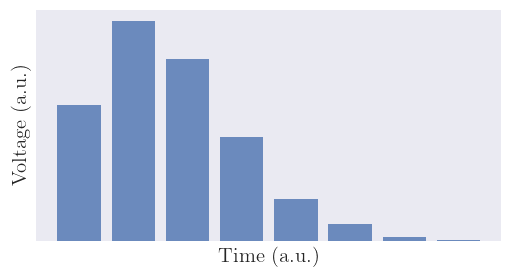

In [348]:
with plt.style.context(STYLE):
    plt.figure(figsize=(6,3), dpi=100)
    plt.bar(np.arange(8),np.bincount(gm.labels),alpha=0.8)
    plt.ylabel("Voltage (a.u.)")
    plt.xlabel("Time (a.u.)")
    plt.yticks([])
    plt.xticks([])
    # plt.savefig('assets/Distribution_PCA.svg', bbox_inches='tight')
    plt.show()

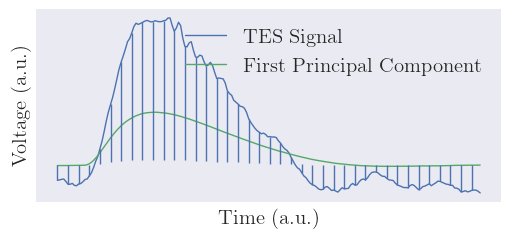

In [ ]:
skip = 5

with plt.style.context(STYLE):
    plt.figure(figsize=(6,2.5), dpi=100)

    plt.plot(TIME, data_test[IDX], linewidth=1, alpha=1, label='TES Signal')
    plt.plot(TIME, first_component, linewidth=1, alpha=1, label='First Principal Component')
    plt.vlines(TIME[::skip], first_component[::skip], data_test[IDX][::skip], linewidth=1, alpha=1)
    plt.ylabel("Voltage (a.u.)")
    plt.xlabel("Time (a.u.)")
    plt.yticks([])
    plt.xticks([])
    plt.legend()
    # plt.savefig('assets/Trace_PCA.svg',format="svg")
    plt.show()